## Prepare Environment

Birinchi navbatda bizga yetarli darajada kuchli bo'lgan GPU kerak bo'ladi va biz Kagglening gpusidan foydalanamiz


Bizdagi GPU ishlayotganini tekshiramiz

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Dec 16 19:35:26 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Biz Whisper modelini fine-tune qilish uchun bir nechta mashhur Python paketlaridan foydalanamiz. datasets[audio] yordamida trening ma'lumotlarini yuklab olib tayyorlaymiz, transformers va accelerate paketlari yordamida modelni yuklab olib o'rgatamiz. Shuningdek, audio fayllarni oldindan ishlov berish uchun soundfile, modelning samaradorligini baholash uchun evaluate va jiwer, metrikalarni yozib borish uchun esa tensorboard paketlaridan foydalanamiz.

In [2]:
!pip install --upgrade --quiet pip
!pip install --upgrade --quiet datasets[audio] transformers accelerate evaluate jiwer tensorboard gradio

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.16.1 requires tensorboard<2.17,>=2.16, but you have tensorboard 2.18.0 which is incompatible.


Bizdan Huggingfacega kirish talab qilinadi

In [3]:
from huggingface_hub import notebook_login

notebook_login()

### Load Dataset

Birinchi muhim qadam sifatida biz kerakli datasetni yuklab olishimiz kerak bo'ladi, Biz  DavronSherbaev/uzbekvoice-filtered datasetini ishlatamiz (O'zbek tilida)

Dataset ancha katta, shuning uchun biz uning bir qismidan foydalanamiz

In [ ]:
from datasets import load_dataset, DatasetDict

common_voice = DatasetDict()

common_voice["train"] = load_dataset("DavronSherbaev/uzbekvoice-filtered", split="train[35000:49000]")
common_voice["test"] = load_dataset("DavronSherbaev/uzbekvoice-filtered", split="train[49000:50000]")

print(common_voice)

Biz o'zimizga kerakli bo'lgan ma'lumotlarnigina qoldiramiz

In [5]:
common_voice = common_voice.remove_columns(['previous_text', 'id', 'client_id', 'duration', 'sentence', 'created_at', 'original_sentence_id', 'sentence_clips_count', 'upvotes_count', 'downvotes_count', 'reported_count', 'reported_reasons', 'skipped_clips', 'gender', 'accent_region', 'native_language', 'year_of_birth'])

print(common_voice)

DatasetDict({
    train: Dataset({
        features: ['path', 'text'],
        num_rows: 14000
    })
    test: Dataset({
        features: ['path', 'text'],
        num_rows: 1000
    })
})


In [6]:
common_voice["train"] = common_voice["train"].shuffle(seed=42)
common_voice["test"] = common_voice["test"].shuffle(seed=42)

## Prepare Feature Extractor, Tokenizer and Data


Jarayoni uch bosqichga bo'linadi:

- Xom audio ma'lumotlarni oldindan ishlovchi **feature extractor**.
- Ma'lumotni ketma-ketlikka moslovchi **model**.
- Model chiqishlarini matn formatiga o'tkazuvchi **tokenizer**.

Transformers kutubxonasida Whisper modeli uchun maxsus WhisperFeatureExtractor va WhisperTokenizer mavjud.

### Load WhisperFeatureExtractor

In [7]:
import transformers
transformers.utils.move_cache()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [8]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-base")

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

### Load WhisperTokenizer

In [9]:
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-base", language="uzbek", task="transcribe")

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

### Combine To Create A WhisperProcessor

In [10]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained("openai/whisper-base", language="uzbek", task="transcribe")

### Prepare Data

Navbat ma'lumotlarni tozalash qismiga, keling avval datasetdan bir ma'lumotni ko'raylik

In [11]:
print(common_voice["train"][0])

{'path': {'path': '8ca20577ac5da729fa47cfe02ae2f417600926f8d7f28aeaae65ad95609dfe2d.mp3', 'array': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
       -4.92353138e-05, -1.93961518e-04, -2.06655124e-04]), 'sampling_rate': 16000}, 'text': "Hozirda O'zbekiston ham ular qatorida."}


`cast_column` metodida foydalanamiz va audioning `sampling_rate`ini o'zgaritishimiz kerak, chunki whisper modeli 16 kHz ma'lumot uchun ishlay oladi

In [12]:
from datasets import Audio

common_voice = common_voice.cast_column("path", Audio(sampling_rate=16000))

Keling endi shu ma'lumotni qayta ko'ramiz

In [13]:
print(common_voice["train"][0])

{'path': {'path': '8ca20577ac5da729fa47cfe02ae2f417600926f8d7f28aeaae65ad95609dfe2d.mp3', 'array': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
       -4.92353138e-05, -1.93961518e-04, -2.06655124e-04]), 'sampling_rate': 16000}, 'text': "Hozirda O'zbekiston ham ular qatorida."}


Model uchun ma'lumot tayyorlash:

- Audio yuklanadi va qayta namuna olinadi.
- Log-Mel spektrogram xususiyatlari olinadi.
- Transkripsiyalar label IDlarga kodlanadi.







In [14]:
def prepare_dataset(batch):

    audio = batch["path"]
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]
    batch["labels"] = tokenizer(batch["text"]).input_ids

    return batch

**Bizda `num_proc` parametri muhim parametr hisoblanadi ya'ni bu bizga multi-processing imkonini beradi. Uni to'g'ri tanlash uchun biz cpu yadrolari soni aniqlashimiz kerak va shunga teng bo'lgan qiymat tanlaymiz**

In [15]:
import os
print(os.cpu_count())

4


`.map` metodi orqali ma'lumotni tayyorlaymiz.

Jarayon biroz vaqt oladi

In [16]:
common_voice = common_voice.map(
    prepare_dataset,
    remove_columns=common_voice.column_names["train"],  
    num_proc=4 
)

Map (num_proc=4):   0%|          | 0/14000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

## Training and Evaluation

Endi ma'lumot tayyorlandi, trening jarayoniga o'tamiz.
Qadamlar:

- **Pre-trained checkpoint yuklash**: modelni to'g'ri o'rnatish va treningga tayyorlash.
- **Data collator aniqlash**: oldindan ishlov berilgan ma'lumotlarni PyTorch tensorga tayyorlash.
- **Baholash metrikalari**: WER (word error rate) metrikasidan foydalanib, modelni baholash.
- **Treaning konfiguratsiyasini belgilash**: Trainer uchun trening jadvalini aniqlash.
Fine-tune qilingan modelni sinov ma'lumotlari ustida baholash

## Load a Model

Bu modelni qurishdan avval men `whisper-base` asosidagi modelni fine tune qilganman.

[jamshidahmadov/whisper-uz](https://huggingface.co/jamshidahmadov/whisper-uz)

Endi pre-trained modelni yana bir bor train qilamiz, albatta yangi ma'lumotlar uchun

In [17]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained("jamshidahmadov/whisper-uz")

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/290M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

Inference paytida modelni faqat O'zbek tilida ishlashga moslashtirish uchun automatic speech recognationni o'chiramiz.



---


**Inference — bu modelni o'qitishdan so'ng, yangi ma'lumotlar bilan test qilish yoki undan natija olish jarayonidir. Masalan, modelni treningdan so'ng, unga audio yoki matn kiritib, modeldan javob olish (masalan, nutqni matnga aylantirish) inference deb ataladi.**

In [18]:
model.generation_config.language = "uzbek"
model.generation_config.task = "transcribe"

model.generation_config.forced_decoder_ids = None

### Define a Data Collator

Data collator `input_features` va `labels`ni alohida ishlaydi. `input_features`ni `feature extractor` bilan, `labels`ni esa `tokenizer` bilan qayta ishlaymiz.

In [19]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [20]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

### Evaluation Metrics

Modelni baholash uchun standart bo'lib hisoblangan `word error rate (WER)`dan foydalanamiz

In [21]:
import evaluate

metric = evaluate.load("wer")

`compute_metrics` funksiyasi -100ni `pad_token_id`ga almashtirib, `predict` va `label` IDlarini matnga decoding qiladi va WERni hisoblaydi.

In [22]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    label_ids[label_ids == -100] = tokenizer.pad_token_id

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

### Define the Training Configuration

Oxirgi qadam: Treaning uchun kerakli parametrlarni yozamiz

In [23]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-uz",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=2000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=1000,
    eval_steps=500,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=True,
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Treaning argumentlarini trainerga, `model`, `dataset`, `data collator` va `compute_metrics` funksiyasi bilan birga uzatamiz:

In [24]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=common_voice["train"],
    eval_dataset=common_voice["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)

/tmp/ipykernel_23/240849381.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [25]:
import torch
torch.cuda.empty_cache()

Treningni boshlashdan oldin, processor obyektini saqlab olish maslahat beriladi. U training jarayonida o'zgarmaydi

In [26]:
processor.save_pretrained(training_args.output_dir)

[]

### Training

**Training jarayoniga ham yetib keldik. Modelni train qilamiz...**

In [ ]:
trainer.train()

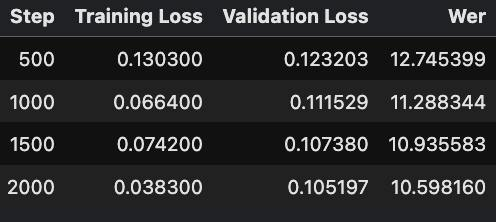

Wer ~ 10 natijasiga ega bo'ldik.
Ko'proq resurslar va datasetning kattaroq qismidan foydalanish orqali bu natijani oshira olamiz

Endi modelni huggingfacega yuklaymiz

In [28]:
kwargs = {
    "dataset_args": "config: uz, split: test",
    "language": "uz",
    "model_name": "Whisper base uz - Jamshid Ahmadov",
    "tasks": "automatic-speech-recognition",
}

 `push_to_hub` buyrug'idan foydalanamiz:

In [29]:
trainer.push_to_hub(**kwargs)

CommitInfo(commit_url='https://huggingface.co/jamshidahmadov/whisper-uz-v3/commit/c6d967e526c4dad09dc354f1c746c4db04e124d5', commit_message='End of training', commit_description='', oid='c6d967e526c4dad09dc354f1c746c4db04e124d5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/jamshidahmadov/whisper-uz-v3', endpoint='https://huggingface.co', repo_type='model', repo_id='jamshidahmadov/whisper-uz-v3'), pr_revision=None, pr_num=None)